# Text Classification Algorithms

In [1]:
from pathlib import Path
import pandas as pd

In [3]:
BASE_PATH = Path("../DATASETS/6/")

df = pd.read_csv(BASE_PATH/"eclipse_jdt.csv.gz")

In [4]:
print(df.columns)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


In [6]:
df[['Issue_id','Priority','Component','Title','Description']].sample(3)

,Issue_id,Priority,Component,Title,Description
40935,303362,P3,Debug,NoSuchMethodError (BreakpointsView.getCheckbox...,Build Identifier: I20100129-1300; ; Using Ecli...
44378,401271,P3,Core,StackOverflowError when searching for a method...,When searching for References in the workspace...
17572,53173,P3,Debug,breakpoint label decorator,Present user experience for setting breakpoint...


In [7]:
df.sample(1).T

,9444
Issue_id,26337
Priority,P3
Component,Text
Duplicated_issue,NaN
Title,ArrayIndexOutOfBoundsException from TextViewer
Description,20021113; found in the log; ; java.lang.ArrayI...
Status,RESOLVED
Resolution,FIXED
Version,2.0
Created_time,2002-11-14 10:32:00 -0500


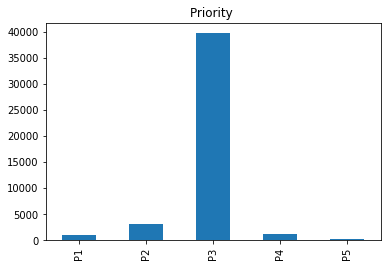

In [14]:
df['Priority'].value_counts().sort_index().plot(kind = 'bar', title = "Priority ");

In [15]:
df['Component'].value_counts()

UI       17479
Core     13669
Debug     7542
Text      5901
APT        406
Doc        299
Name: Component, dtype: int64

### Building a Text Classification System

### Date Preparation

In [17]:
df = df[['Title', 'Description', 'Priority']]
df = df.dropna()

In [19]:
df['text'] = df['Title'] + ' ' + df['Description']

In [20]:
df.drop(columns=['Title', 'Description'], inplace=True)

In [24]:
import html
import re

def clean(text):
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [25]:
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2)

,Priority,text
22811,P3,Main class in Run dialog should chop trailing ...
25931,P3,Java Editor Preferences page: mnemonics only w...


### Train-Test Split

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                            df['text'],
                                            df['Priority'],
                                            test_size=.2,
                                            random_state=42,
                                            stratify=df['Priority']
                                        )

In [28]:
print("Size of Training Data ", X_train.shape[0])
print("Size of Test Data ", X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


### Training the Machine Learning Model

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix

In [31]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1, 2), stop_words="english")

In [32]:
X_train_tf = tfidf.fit_transform(X_train)

In [38]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

### Model Evaluation

In [39]:
X_test_tf = tfidf.transform(X_test)

In [40]:
Y_pred = model1.predict(X_test_tf)

In [42]:
print("Accuray Score: ", accuracy_score(Y_test, Y_pred))

Accuray Score:  0.8761513705471091


In [44]:
from sklearn.dummy import DummyClassifier

In [46]:
clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_train, Y_train)

DummyClassifier(strategy='most_frequent')

In [47]:
Y_pred_baseline = clf.predict(X_test)

In [49]:
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.8769281988680502


In [62]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

C:\Users\HP\.virtualenvs\Text-Analysis-workouts-4nsmzFq6\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


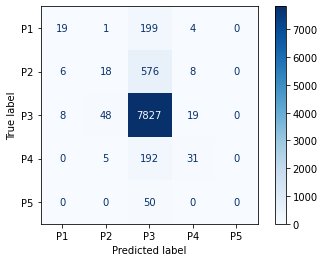

In [60]:
plot_confusion_matrix(model1,X_test_tf,
 Y_test, values_format='d',
 cmap=plt.cm.Blues)
plt.show()

In [63]:
print(classification_report(Y_test, Y_pred))

C:\Users\HP\.virtualenvs\Text-Analysis-workouts-4nsmzFq6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\.virtualenvs\Text-Analysis-workouts-4nsmzFq6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



C:\Users\HP\.virtualenvs\Text-Analysis-workouts-4nsmzFq6\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# Class Imbalance

In [67]:
df_sample_p3 = df[df['Priority'] == "P3"].sample(4000)
df_sample_rest = df[df['Priority'] != "P3"]

df_balanced = pd.concat([df_sample_rest, df_sample_p3])

In [68]:
df_balanced['Priority'].value_counts()

P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: Priority, dtype: int64

## Final Text Classification

In [69]:
df = df_balanced[['text', 'Priority']]
df = df.dropna()

In [70]:
df['text'] = df['text'].apply(clean)

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                    df['Priority'],
                                    test_size=0.2,
                                    random_state=42,
                                    stratify=df['Priority'])


In [72]:
print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])


Size of Training Data  7636
Size of Test Data  1909


In [73]:
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [74]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

LinearSVC(random_state=0, tol=1e-05)

In [75]:
X_test_tf = tfidf.transform(X_test)
Y_pred = model1.predict(X_test_tf)
print('Accuracy Score - ', accuracy_score(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

Accuracy Score -  0.5034049240440021
              precision    recall  f1-score   support

          P1       0.48      0.30      0.37       223
          P2       0.44      0.46      0.45       608
          P3       0.56      0.67      0.61       800
          P4       0.45      0.36      0.40       228
          P5       0.29      0.04      0.07        50

    accuracy                           0.50      1909
   macro avg       0.44      0.36      0.38      1909
weighted avg       0.49      0.50      0.49      1909



In [76]:
# Comparing

In [77]:
clf = DummyClassifier(strategy='stratified')
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.32949188056574125


In [78]:
frame = {'text': X_test, 'actual': Y_test, 'predicted': Y_pred}
result = pd.DataFrame(frame)

In [80]:
result[result['actual'] == result['predicted']].sample(3)

,text,actual,predicted
10014,IllegalArgumentException with multiple editors...,P2,P2
8046,Add Variable Window Small/Not Persistant 1.It ...,P3,P3
15585,Implementing deprecated methods should NOT yie...,P3,P3


In [81]:
result[result['actual'] != result['predicted']].sample(3)

,text,actual,predicted
35049,Something has changed on org.eclipse.jdt.core....,P3,P2
2808,Ctrl-Space cannot be used on Simplified Chines...,P4,P2
654,Revisit use of run(false;*;*) (1GCC4EV) The me...,P4,P3


In [82]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
 (result['actual'] == result['predicted'])].sample(2)

,text,actual,predicted
8499,NPE variable details stop showing I noticed th...,P1,P1
11332,Java Example Project: Still uses JRE_LIB 20030...,P2,P2


In [83]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
 (result['actual'] != result['predicted'])].sample(2)

,text,actual,predicted
1697,test fails MethodEntryBreakpointTests#testDefe...,P1,P2
35032,blank threads in debug view In I20070410-1043;...,P2,P3


### Using Cross-Validation to Estimate Realistic Accuracy Metrics

In [87]:
from sklearn.model_selection import cross_val_score

In [85]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['text']).toarray()


In [88]:
scores = cross_val_score(estimator=model1,
                              X=df_tf,
                              y=df['Priority'],
                              cv=5
                        )

In [89]:
print ("Validation scores from each iteration of the cross validation ", scores)
print ("Mean value across of validation scores ", scores.mean())
print ("Standard deviation of validation scores ", scores.std())

Validation scores from each iteration of the cross validation  [0.47459403 0.44002095 0.44211629 0.41749607 0.37454164]
Mean value across of validation scores  0.4297537977998952
Standard deviation of validation scores  0.03306818922468171


### Performing Hyperparameter Tuning with Grid Search


In [92]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [91]:
training_pipeline = Pipeline(
                        steps = [("tfidf", TfidfVectorizer(stop_words='english')),
                                 ('model', LinearSVC(random_state=42, tol = 1e-5))]
                    )

In [93]:
grid_param = [{
 'tfidf__min_df': [5, 10],
 'tfidf__ngram_range': [(1, 3), (1, 6)],
 'model__penalty': ['l2'],
 'model__loss': ['hinge'],
 'model__max_iter': [10000]
}, {
 'tfidf__min_df': [5, 10],
 'tfidf__ngram_range': [(1, 3), (1, 6)],
 'model__C': [1, 10],
 'model__tol': [1e-2, 1e-3]
}]

In [94]:
gridSearchProcessor = GridSearchCV(
                            estimator=training_pipeline,
                            param_grid=grid_param,
                            cv=5
                    )

In [95]:
gridSearchProcessor.fit(df['text'], df['Priority'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('model',
                                        LinearSVC(random_state=42,
                                                  tol=1e-05))]),
             param_grid=[{'model__loss': ['hinge'], 'model__max_iter': [10000],
                          'model__penalty': ['l2'], 'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]},
                         {'model__C': [1, 10], 'model__tol': [0.01, 0.001],
                          'tfidf__min_df': [5, 10],
                          'tfidf__ngram_range': [(1, 3), (1, 6)]}])

In [96]:
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}


In [97]:
best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

Best result identified by grid search  0.4579360921948664


In [98]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)

In [99]:
gridsearch_results[['rank_test_score', 'mean_test_score',
                 'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
2,1,0.457936,"{'model__loss': 'hinge', 'model__max_iter': 10..."
3,2,0.454898,"{'model__loss': 'hinge', 'model__max_iter': 10..."
0,3,0.454269,"{'model__loss': 'hinge', 'model__max_iter': 10..."
1,4,0.452279,"{'model__loss': 'hinge', 'model__max_iter': 10..."
10,5,0.436668,"{'model__C': 1, 'model__tol': 0.001, 'tfidf__m..."
